### Data Scraping

In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [5]:
response = requests.get('http://www.worldbirdnames.org/master_ioc-names_xml.xml')

In [6]:
response.status_code

200

In [7]:
soup = BeautifulSoup(response.text, 'xml')

In [8]:
speciesTree = []
for o in soup.find_all('order'):
    oname = o.find('latin_name').text
    for f in o.find_all('family'):
        fname = f.find('latin_name').text
        for g in f.find_all('genus'):
            gname = g.find('latin_name').text
            gAuthority = g.find('authority').text
            rank = 0
            for s in g.find_all('species'):
                rank +=1
                sname = s.find('latin_name').text
                toApp = [rank, oname, fname, gname, sname, gAuthority, s.find('authority').text, s.find('breeding_regions').text]
                speciesTree.append(toApp)

In [9]:
def cleanNames(nameCol):
    toRet = []
    for n in nameCol:
        #print(n)
        n = n.replace(',', '')
        n = n.replace('& ', '')
        n = n.replace('et al', 'EtAl')
        n = n.strip()
        #print(n)
        toRet.append(n)
    return toRet

### Cleaning

In [10]:
df = pd.DataFrame(speciesTree)
df.columns = ['Rank', 'Order', 'Family','Genus','Species','GAuth','SAuth','BreedRegion']

df['OrigG'] = [a.count(')') == 0 for a in df['SAuth']]
df['SAuth'] = df['SAuth'].str.replace( ')', '')
df['SAuth'] = df['SAuth'].str.replace( '(', '')

df['SDate'] = [int(a[-4:]) for a in df['SAuth']]
df['SAuthors'] = [ a[:-4] for a in df['SAuth']]

df['GDate'] = [int(a[-4:]) if a != 'E' else 1816 for a in df['GAuth'] ]
df['GAuthors'] = [a[:-4] if a != 'E' else 'Vieillot' for a in df['GAuth']]

df['SAuthors'] = cleanNames(df['SAuthors'])
df['GAuthors'] = cleanNames(df['GAuthors'])
df['BreedRegion'] = cleanNames(df['BreedRegion'])

df = df.drop(['GAuth','SAuth'], axis = 'columns')
df['DateRank'] = df.groupby('Genus')['SDate'].rank(ascending = True, method = 'min').astype(int)
#df['FullName'] = df['Order'] +' '+ df['Family']+' ' + df['Genus']+'_' + df['Species'].str[:-2]

spg = df.groupby('Genus')['Species'].count()
spg.name = 'SpG'

df = df.merge(pd.DataFrame(spg), left_on= 'Genus', right_index= True)


In [11]:
df.head(20)

Rank             Order         Family        Genus           Species  \
0      1  STRUTHIONIFORMES  Struthionidae     Struthio           camelus   
1      2  STRUTHIONIFORMES  Struthionidae     Struthio     molybdophanes   
2      1        RHEIFORMES        Rheidae         Rhea         americana   
3      2        RHEIFORMES        Rheidae         Rhea           pennata   
4      1    APTERYGIFORMES    Apterygidae      Apteryx         australis   
5      2    APTERYGIFORMES    Apterygidae      Apteryx          mantelli   
6      3    APTERYGIFORMES    Apterygidae      Apteryx              rowi   
7      4    APTERYGIFORMES    Apterygidae      Apteryx            owenii   
8      5    APTERYGIFORMES    Apterygidae      Apteryx           haastii   
9      1    CASUARIIFORMES    Casuariidae    Casuarius         casuarius   
10     2    CASUARIIFORMES    Casuariidae    Casuarius          bennetti   
11     3    CASUARIIFORMES    Casuariidae    Casuarius  unappendiculatus   
12     1    CASUARIIFORMES    Casuariidae     Dromaius   novaehollandiae   
13     1      TINAMIFORMES      Tinamidae      Tinamus               tao   
14     2      TINAMIFORMES      Tinamidae      Tinamus        solitarius   
15     3      TINAMIFORMES      Tinamidae      Tinamus           osgoodi   
16     4      TINAMIFORMES      Tinamidae      Tinamus             major   
17     5      TINAMIFORMES      Tinamidae      Tinamus          guttatus   
18     1      TINAMIFORMES      Tinamidae  Nothocercus        bonapartei   
19     2      TINAMIFORMES      Tinamidae  Nothocercus            julius   

   BreedRegion  OrigG  SDate                                 SAuthors  GDate  \
0           AF   True   1758                                 Linnaeus   1758   
1           AF   True   1883                                Reichenow   1758   
2           SA  False   1758                                 Linnaeus   1760   
3           SA   True   1834                                d'Orbigny   1760   
4           AU   True   1813                                     Shaw   1813   
5           AU   True   1852                                 Bartlett   1813   
6           AU   True   2003  Tennyson Palma Robertson Worthy Gill BJ   1813   
7           AU   True   1847                                    Gould   1813   
8           AU   True   1872                                    Potts   1813   
9           AU  False   1758                                 Linnaeus   1760   
10          AU   True   1857                                    Gould   1760   
11          AU   True   1860                                    Blyth   1760   
12          AU  False   1790                                   Latham   1816   
13          SA   True   1815                                 Temminck   1783   
14          SA  False   1819                                 Vieillot   1783   
15          SA   True   1949                                  Conover   1783   
16       MA SA  False   1789                                Gmelin JF   1783   
17          SA   True   1863                                  Pelzeln   1783   
18       MA SA  False   1867                                  Gray GR   1856   
19          SA  False   1854                                Bonaparte   1856   

     GAuthors  DateRank  SpG  
0    Linnaeus         1    2  
1    Linnaeus         2    2  
2     Brisson         1    2  
3     Brisson         2    2  
4        Shaw         1    5  
5        Shaw         3    5  
6        Shaw         5    5  
7        Shaw         2    5  
8        Shaw         4    5  
9     Brisson         1    3  
10    Brisson         2    3  
11    Brisson         3    3  
12   Vieillot         1    1  
13    Hermann         2    5  
14    Hermann         3    5  
15    Hermann         5    5  
16    Hermann         1    5  
17    Hermann         4    5  
18  Bonaparte         2    3  
19  Bonaparte         1    3

In [12]:
ats = df.loc[6,'SAuthors']

In [17]:
a = "Ab"
a.islower()

False

In [14]:
ats.split(' ')

['Tennyson', 'Palma', 'Robertson', 'Worthy', 'Gill', 'BJ']

In [22]:
lst = []
for e in ats.split(' '):
    if e.isupper():
        prev = lst.pop()
        lst.append(' '.join([prev, e]).lower())
    else:
        lst.append(e.lower())

lst
        
    

['tennyson', 'palma', 'robertson', 'worthy', 'gill bj']

In [36]:
df.to_csv('BirdRank.csv')
df.to_csv('BirdRank.tsv', sep = '\t')

### Initial EDA

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [39]:
def plotSpg(data, num):
    df = data[data['SpG']==num]
    row = int(num/3)+1
    for i in range(1,num+1):
        #plt.figure(figsize = (10,8))
        plt.subplot(row,3,i)
        plt.hist(df[df['Rank'] ==i]['DateRank'])
        plt.title('Linear Rank = '+ str(i))
        plt.xlabel('Date-Rank')
        #plt.ylim(ymax = 130)
        #plt.show()

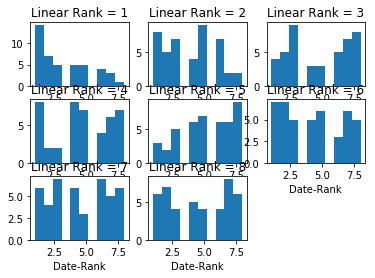

In [40]:
plotSpg(df, 8)

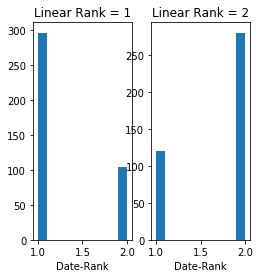

In [41]:
plotSpg(df,2)

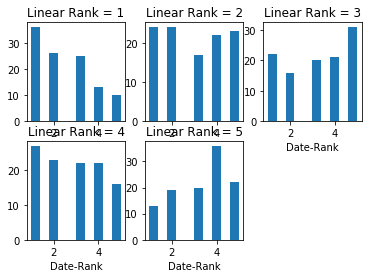

In [31]:
plotSpg(df, 5)

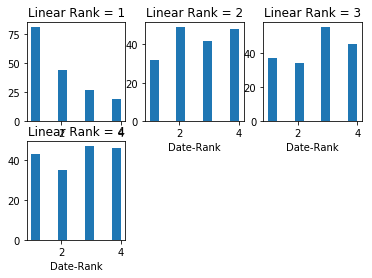

In [32]:
plotSpg(df, 4)

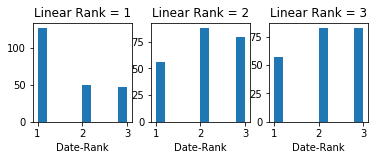

In [33]:
plotSpg(df, 3)

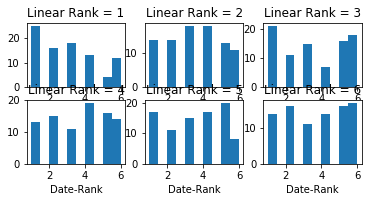

In [34]:
plotSpg(df, 6)

### Next Steps

It does look like there is some pattern to the rank-order an description date of the various taxa. The next thing to do will be to define and create metrics to more fully describe what those patterns are.  

Also, next it will be important to start to standardize and investigate the distriution of authorship.

In [2]:
caps = "AGB"
caps.isupper()

True

split on space

In [151]:
for idx in df.index:
    au = df.loc[idx,'GAuthors']
    if au.count(' et al')>0:
        print(idx)
    #try:
     #   z = au.split(',')[1]
    #except:
    #    print(idx)

1150
2587
4552
4553
4554
4555
4958
4959
4960
4961
4962
4963
5104
5105
5703
8125
8126
8127
8128
8998
8999
10285


In [35]:
for idx in df.index:
    try:
        df.loc[idx,'SAuth'].split(',')[1]
    except:
        print(idx)

6
24
27
38
44
49
103
106
110
118
122
126
156
179
182
223
262
280
304
305
322
365
392
414
415
422
440
444
447
454
455
465
545
551
554
574
575
628
634
638
641
655
683
694
697
700
702
704
717
726
772
778
789
794
821
823
827
843
844
914
916
975
998
1015
1017
1057
1063
1074
1080
1086
1104
1111
1117
1138
1163
1165
1189
1190
1194
1197
1211
1231
1234
1238
1264
1266
1268
1269
1279
1280
1282
1299
1308
1312
1326
1329
1341
1362
1370
1384
1403
1404
1478
1504
1512
1530
1532
1559
1561
1613
1638
1639
1750
1775
1795
1852
1857
1866
1887
1912
1913
1925
1932
1946
1971
1972
1973
1974
1980
2005
2018
2030
2031
2070
2086
2087
2097
2112
2114
2124
2137
2180
2204
2209
2211
2214
2216
2222
2231
2311
2326
2346
2364
2372
2375
2382
2391
2393
2398
2399
2408
2413
2414
2423
2425
2426
2429
2430
2437
2442
2443
2459
2477
2481
2483
2496
2508
2511
2512
2514
2529
2541
2548
2556
2567
2568
2569
2572
2584
2585
2614
2659
2669
2670
2681
2692
2694
2711
2712
2718
2721
2725
2732
2741
2760
2775
2801
2802
2835
2850
2855
2861
2870
2872


#### Deprecated

In [23]:
speciesTree = {}
for o in soup.find_all('order'):
    oname = o.find('latin_name').text
    #print(oname)
    speciesTree[oname] = {}
    for f in o.find_all('family'):
        fname = f.find('latin_name').text
        #print(fname)
        speciesTree[oname][fname]= {}
        for g in f.find_all('genus'):
            gname = g.find('latin_name').text
            #print(gname)
            speciesTree[oname][fname][gname] = {'GAuthority': g.find('authority').text}
            for s in g.find_all('species'):
                sname = s.find('latin_name').text
                #print(sname)
                #print(s.find('authority').text)
                speciesTree[oname][fname][gname][sname] = {'SAuthourity': s.find('authority').text,
                                                           'Breeding' : s.find('breeding_regions').text}

Linnaeus, 1758
Reichenow, 1883
(Linnaeus, 1758)
d'Orbigny, 1834
Shaw, 1813
Bartlett, 1852

Gould, 1847
Potts, 1872
(Linnaeus, 1758)
Gould, 1857
Blyth, 1860
(Latham, 1790)
Temminck, 1815
(Vieillot, 1819)
Conover, 1949
(Gmelin, JF, 1789)
Pelzeln, 1863
(Gray, GR, 1867)
(Bonaparte, 1854)
(Gray, GR, 1867)
(Rothschild, 1897)
(Gmelin, JF, 1789)
(Hermann, 1783)

(Temminck, 1815)
(Temminck, 1815)

(Temminck, 1815)
Zimmer, JT, 1938
(Pelzeln, 1863)
(zu Wied-Neuwied, 1820)
(Tschudi, 1844)
(Lesson, PA, 1842)
(Sclater, PL, 1860)
(Chapman, 1915)
(Gmelin, JF, 1789)
(Pelzeln, 1863)

(Wagler, 1827)
(Chapman, 1929)
(Temminck, 1815)
(Temminck, 1815)
Gray, GR, 1867

(Gray, GR, 1867)
(Kittlitz, 1830)
(Burmeister, 1860)
(Gray, GR, 1867)

(von Spix, 1825)
(von Spix, 1825)
Gray, GR, 1867
(Temminck, 1815)
Conover, 1937
(Temminck, 1815)
Geoffroy Saint-Hilaire, I, 1832
(Lillo, 1905)
Vigors, 1837
Oustalet, 1890
(Linnaeus, 1766)
(Linnaeus, 1766)
(Oken, 1816)
(Latham, 1798)
(Linnaeus, 1766)
(Linnaeus, 1758)
Schlegel

(Salvin, 1895)
(Vigors, 1827)
(Vieillot, 1818)
(Lawrence, 1868)
(Sclater, PL, 1860)
(Hartert, 1902)
(Temminck, 1813)
(Milne-Edwards, 1873)
(Prévost, 1843)
(Linnaeus, 1758)
(Rüppell, 1837)
(Reichenow, 1910)
(Latham, 1790)
(Temminck, 1809)
(Frivaldszky, 1838)
(Sundevall, 1857)
(Erlanger, 1901)

(Rüppell, 1837)
(Sundevall, 1857)
(Gmelin, JF, 1789)
(Hermann, 1804)
(Scopoli, 1786)
(Linnaeus, 1766)
(Wagler, 1827)
(Linnaeus, 1766)
Bonaparte, 1854
Bonaparte, 1854
Salvadori, 1892
Salvadori, 1887
Wallace, 1864
Meyer, AB, 1884
Wallace, 1865
Bonaparte, 1854
(Temminck, 1821)
Blyth, 1846
Salvadori, 1876
Ramsay, EP, 1878
(Temminck, 1835)
(Temminck, 1824)
(Sclater, PL, 1877)
(Gould, 1856)


(Temminck, 1835)
(Wagler, 1827)
(Sharpe, 1902)
(Linnaeus, 1766)
(Temminck, 1809)
(Hartlaub, 1865)
(Linnaeus, 1766)
(Linnaeus, 1758)
Gould, 1848
Pucheran, 1853
Gray, GR, 1862

(Latham, 1790)
(Temminck, 1809)
(Gould, 1841)
(Temminck, 1822)
Gould, 1842
(Temminck, 1821)

Gray, GR, 1849
(Latham, 1801)
Collett, 1898
Goul

Lesson, R, 1838
Lichtenstein, MHK, 1839
(Lafresnaye, 1840)
Swainson, 1827
(Gould, 1836)
Lesson, R, 1842
Sclater, PL, 1853
(Swainson, 1838)
(Linnaeus, 1766)
Gould, 1858
(von Spix, 1824)
(Vieillot, 1818)
(Du Bus de Gisignies, 1847)
(Leadbeater, 1829)
(Sandbach, 1837)
(Temminck, 1824)

Bonaparte, 1850
(Cassin, 1859)
(Cassin, 1857)
Cabanis, 1889
Shaw, 1798
Lichtenstein, AAH, 1793
Statius Müller, PL, 1776
Vieillot, 1817
(Sharpe, 1892)
Vieillot, 1817
Smith, A, 1834
Oustalet, 1882
Vieillot, 1817
Reichenow, 1882
Latham, 1801
Pallas, 1773
Linnaeus, 1766
Linnaeus, 1767
Latham, 1801
Linnaeus, 1758
Vieillot, 1817
Linnaeus, 1758
Shaw, 1806
Gmelin, JF, 1788

Linnaeus, 1758
Bechstein, 1811

Olson, 1975
(Sharpe, 1871)
(Hartlaub, 1858)
(Miller, JF, 1784)
(Ogilvie-Grant, 1901)
(Ogilvie-Grant, 1901)
(Neumann, 1903)
(Stephens, 1826)
(Vieillot, 1819)
(Rüppell, 1845)
(Boddaert, 1783)
(Vigors, 1825)


(Shelley, 1888)
(Sundevall, 1850)
(Temminck, 1823)
Hartlaub, 1865
(Cabanis, 1868)
(Ogilvie-Grant, 1891)
(Lic

Lesson, R, 1844
Sclater, PL, 1855
Sclater, PL, 1857
(Linnaeus, 1764)
Chapman, 1921
Lafresnaye, 1844
Lafresnaye, 1853
(Lichtenstein, MHK, 1823)
Sclater, PL, 1856
Sclater, PL, 1869
Zimmer, JT, 1937
Sclater, PL, 1855

Sclater, PL, 1858
(Sclater, PL, 1859)
d'Orbigny, 1837

(Hellmayr, 1904)

(Shaw, 1809)
Pelzeln, 1868
Pelzeln, 1868
Hellmayr, 1924
Swainson, 1825
Sclater, PL, 1858


Vieillot, 1816
Swainson, 1825
Vieillot, 1816
(Linnaeus, 1766)
(zu Wied-Neuwied, 1831)
(Lichtenstein, MHK, 1823)
(Lafresnaye, 1850)
(Leach, 1814)
Gyldenstolpe, 1941
(Vieillot, 1816)
(Such, 1825)
(Lichtenstein, MHK, 1823)
(Vieillot, 1816)
(Pelzeln, 1868)
Zimmer, JT, 1944
(Vieillot, 1816)
(Vieillot, 1819)
Chapman, 1924
(Linnaeus, 1766)
Berlioz, 1938
(Lawrence, 1861)
(Lawrence, 1863)
(Sclater, PL, 1855)
(Boddaert, 1783)
(von Berlepsch, 1901)

Ridgway, 1888
(Snethlage, E, 1907)
(Hellmayr, 1907)
(Pelzeln, 1868)


(Gould, 1855)
Hellmayr, 1907
(Cabanis, 1847)
(Hellmayr, 1905)
(Temminck, 1822)
(Bertoni, AW, 1901)
(de Filip

Gould, 1841
(Blyth, 1847)
(Ogilvie-Grant, 1894)
(Blasius, W, 1890)
(Bonaparte, 1850)
Salvadori, 1876
(De Vis, 1894)
(Walden, 1872)
(Walden, 1872)
(Sharpe, 1887)
Salvadori, 1890
Gould, 1843
Jardine, 1849
Sclater, PL, 1874
Wallace, 1864
Strickland, 1849
Rand, 1940
Wallace, 1863
(Latham, 1801)
Ramsay, EP, 1878
Ramsay, EP, 1876
Pucheran, 1853
Ramsay, EP, 1878
Mayr, 1931
Gray, GR, 1860
(Gmelin, JF, 1789)
Gray, GR, 1860
Oustalet, 1875
Bonaparte, 1850
Gould, 1843
(Peale, 1849)
Hartert, 1929
Mayr, 1932
Hartert, 1897
Mayr, 1931
Schlegel, 1871
Reichenow, 1899
(Latham, 1801)
Gray, GR, 1858

Sclater, PL, 1883
Gray, GR, 1862
Hartert, 1903
Gould, 1840

(van Oort, 1909)
(Bonaparte, 1850)
Ramsay, EP, 1885
(Rothschild, 1911)

(Latham, 1801)
Hartert, 1905
(Shaw, 1809)
(Jardine, 1831)
Bonaparte, 1853
Smith, A, 1836
Drapiez, 1828
Barboza du Bocage, 1878

Linnaeus, 1758
Linnaeus, 1758

(Schalow, 1875)
Lesson, R, 1831
Hartlaub, 1882
Valenciennes, 1826
Linnaeus, 1758
(Vigors, 1831)
Ogilvie-Grant, 1894
Sharpe

Sundevall, 1850
(Smith, A, 1829)
Sundevall, 1850
(Fraser, 1843)
van Someren, 1920
Barboza du Bocage, 1894
(Blyth, 1844)
Vigors, 1831
Gould, 1863
David, 1873
Godwin-Austen, 1870
David, 1874
Sykes, 1832
Blyth, 1847
Hodgson, 1836
Horsfield, 1821
Hodgson, 1836
Swinhoe, 1859
Walden, 1873
Blyth, 1845
(Blyth, 1842)
(Blyth, 1845)
Ripley, 1948
(Verreaux, J, 1871)

(Bingham, 1903)
(Rippon, 1904)

(Moore, F, 1854)
(Mandelli, 1873)

(Temminck, 1828)
(Baker, ECS, 1920)

Blyth, 1844
(Temminck, 1836)
(Müller, S, 1836)
(Godwin-Austen, 1877)
(Temminck, 1836)
(Strickland, 1848)
(Temminck, 1836)
(Temminck, 1821)
(Blyth, 1842)
(Temminck, 1823)
(Deignan, 1939)
(Hume, 1873)
Harington, 1915
(Blyth, 1847)
(Blyth, 1844)
(Blyth, 1844)
(Franklin, 1831)
(Jerdon, 1839)
(Horsfield, 1822)
(Bonaparte, 1850)
(Bonaparte, 1850)
(Delacour, 1932)
Sharpe, 1877

Horsfield, 1821
(Blyth, 1844)
(Walden, 1874)
Yen, 1932
(Blyth, 1847)
(Hodgson, 1837)

(Mandelli, 1873)
(Hume, 1874)
Gould, 1863
(Salvadori, 1879)
(Jerdon, 1841)
(Bo

Blyth, 1855
(Gould, 1836)
Blyth, 1845
Tristram, 1864
(Gould, 1838)
(Smith, A, 1836)



Sharpe, 1891
Heuglin, 1871
(Statius Müller, PL, 1776)
(Vieillot, 1817)
(Rüppell, 1840)
(Oustalet, 1890)
Reichenow, 1904
(Smith, A, 1836)
(Lichtenstein, MHK, 1823)
Pleske, 1896
(Linnaeus, 1758)
(Lichtenstein, MHK, 1823)
(Bonaparte, 1850)
(Hartlaub, 1880)
(Bonaparte, 1850)
(Linnaeus, 1766)
Blyth, 1845
(Sundevall, 1850)
(Heuglin, 1862)
(Burton, 1838)
(Linnaeus, 1766)
(Oustalet, 1892)
Adams, 1859
(Przewalski, 1876)
Verreaux, J, 1871
(Blanford, 1871)
(Hume, 1876)
(Meinertzhagen, R, 1937)
(Vieillot, 1817)
Smith, A, 1836
(Rüppell, 1845)
Smith, A, 1836
(Cretzschmar, 1827)
Sharpe, 1895
Büttikofer, 1888
Reichenow, 1887
(Bonaparte, 1850)

(Latham, 1790)
(Smith, A, 1836)
(Daudin, 1800)
(Vigors, 1831)
(Daudin, 1802)
Chapin, 1932
(Sharpe, 1908)
Reichenow, 1904
(Shelley, 1893)
(Hartlaub, 1887)
(Cabanis, 1876)
(Lichtenstein, MHK, 1823)
Smith, A, 1828
(Vieillot, 1805)
(Sharpe, 1902)
Shelley, 1887
(Linnaeus, 1766)
(Ba